calibrating stereo...
computing undistortion maps...
Processing data/stereo/captures/rect_raiz_apriltags/rect_left_15.jpg and data/stereo/captures/rect_raiz_apriltags/rect_right_15.jpg
Detected tag 1 with corners: [[1057.26806641  873.41723633]
 [1121.81311035  893.59033203]
 [1117.43017578  945.58233643]
 [1054.07971191  927.98779297]]
Detected tag 4 with corners: [[1358.66503906  959.67858887]
 [1367.18212891  909.3850708 ]
 [1417.08447266  886.53594971]
 [1409.20397949  936.59857178]]
Detected tag 4 with corners: [[873.61517334 971.0435791 ]
 [866.83111572 920.9041748 ]
 [930.35296631 896.85131836]
 [935.15289307 945.76849365]]


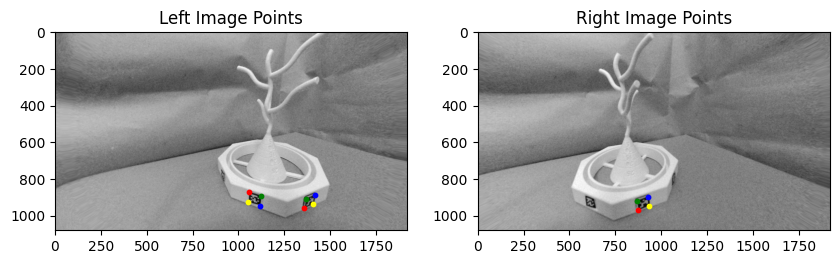

In [ ]:
import os

import numpy as np
import cv2
import open3d as o3d

from calibration.stereo_calibration import do_calibration
from calibration.undistort import undistort
from calibration.calib import detect_apriltags
from disparity.disp import get_disparity_method, compute_disparity
from utils import read_pickle
from images import prepare_imgs, process_images
from filter_point_cloud import filter_point_cloud
from refinement.icp import *

################## SETUP

calib_images_dir = "data/stereo/calib/24mm_board"
calib_results_dir = "data/stereo"

calib_stereo_file = os.path.join(calib_results_dir, "stereo_calibration.pkl")
undistort_maps_file = os.path.join(calib_results_dir, "stereo_maps.pkl")

checkerboard = (9,6)
square_size_mm = 24.2

captures_dir = "data/stereo/captures/raiz_apriltags"
rectified_dir = "data/stereo/captures/rect_raiz_apriltags"

################# CALIBRATION

# calculate calibration
calib_results, maps = do_calibration(
    checkerboard=checkerboard,
    square_size=square_size_mm,
    calib_images_dir=calib_images_dir,
    calib_results_dir=calib_results_dir
)

# create undistortion maps
undistort(
    calib_results,
    maps,
    captures_dir,
    rectified_dir
)

################ RECONSTRUCTION

# input images
input_dir = rectified_dir

# Known object to detect in images
tag_family = "tag25h9"

# read calibration files
calibration = read_pickle(calib_stereo_file)
maps = read_pickle(undistort_maps_file)

# separate calibration params
left_K = calibration["left_K"]
left_dist = calibration["left_dist"]
right_K = calibration["right_K"]
right_dist = calibration["right_dist"]
image_size = calibration["image_size"]
T = calibration["T"]

left_map_x = maps["left_map_x"]
left_map_y = maps["left_map_y"]
right_map_x = maps["right_map_x"]
right_map_y = maps["right_map_y"]
P1 = maps["P1"]
P2 = maps["P2"]
Q = maps["Q"]

# baseline in mm as x-axis distance from left to right camera
baseline_mm = T[0]

# configures model, defines disparity method and returns calibration object
method = get_disparity_method(
        image_size,
        P1,
        baseline_meters = baseline_mm / 1000
    )

left_file_names, right_file_names = prepare_imgs(input_dir)

all_points_3d = np.empty((0, 3))
all_colors = np.empty((0, 3))
all_camera_extrinsics = []
export_num = 0

for left_file_name, right_file_name in zip([left_file_names[0]], [right_file_names[0]]):
        print(f"Processing {left_file_name} and {right_file_name}")

        image_size, left_image, right_image = process_images(left_file_name, right_file_name, image_size)
        left_size = (left_image.shape[1], left_image.shape[0])
        right_size = (right_image.shape[1], right_image.shape[0])

        # rectify images
        left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
        right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

        ######### POSE ##################

        left_object_points, left_image_points = detect_apriltags(left_image_rectified,tag_family)
        right_object_points, right_image_points = detect_apriltags(right_image_rectified, tag_family)

        import matplotlib.pyplot as plt

        # Plot image points in left image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        colors = ['red', 'green', 'blue', 'yellow']
        
        # Plot image points in left image
        plt.imshow(left_image_rectified, cmap='gray')
        for i, point in enumerate(left_image_points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], marker='o', s=10)
        plt.title('Left Image Points')

        # Plot image points in right image
        plt.subplot(1, 2, 2)
        plt.imshow(right_image_rectified, cmap='gray')
        for i, point in enumerate(right_image_points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], marker='o', s=10)
        plt.title('Right Image Points')

        plt.show()

In [44]:
import matplotlib.pyplot as plt

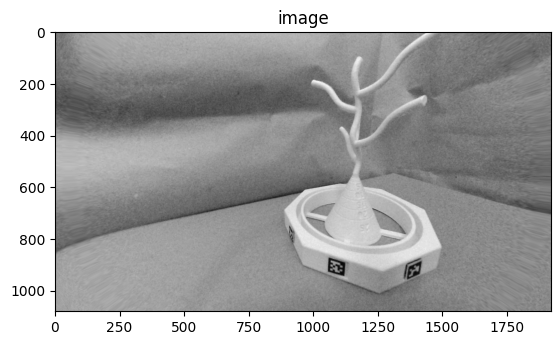

In [45]:
import matplotlib.pyplot as plt
plt.imshow(left_image_rectified, cmap='gray')
plt.title('image')
plt.show()


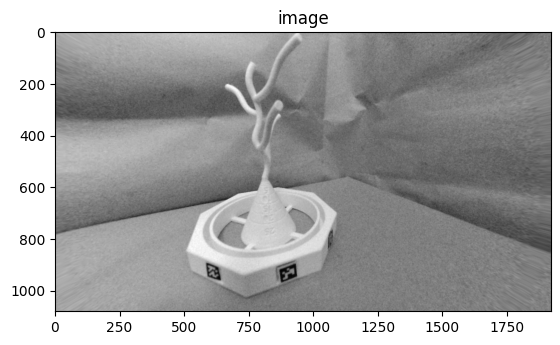

In [46]:
import matplotlib.pyplot as plt
plt.imshow(right_image_rectified, cmap='gray')
plt.title('image')
plt.show()

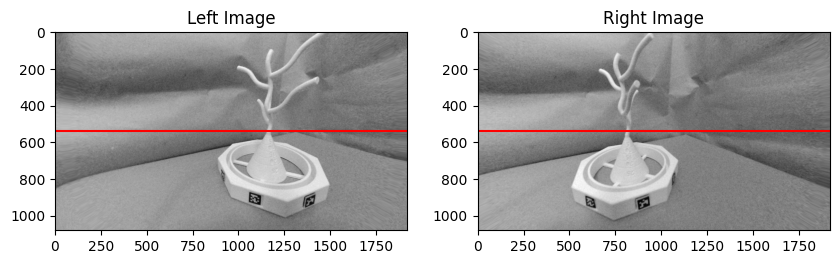

In [47]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(left_image_rectified, cmap='gray')
axes[0].set_title('Left Image')
axes[0].axhline(y=left_image_rectified.shape[0] // 2, color='red', linestyle='-')

axes[1].imshow(right_image_rectified, cmap='gray')
axes[1].set_title('Right Image')
axes[1].axhline(y=right_image_rectified.shape[0] // 2, color='red', linestyle='-')

plt.show()

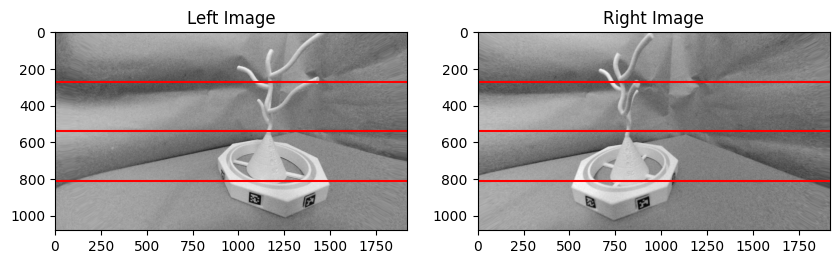

In [48]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define y values for the horizontal lines
y_values = [left_image_rectified.shape[0] // 4, left_image_rectified.shape[0] // 2, 3 * left_image_rectified.shape[0] // 4]

# Plot left image with multiple horizontal lines
axes[0].imshow(left_image_rectified, cmap='gray')
axes[0].set_title('Left Image')
for y in y_values:
    axes[0].axhline(y=y, color='red', linestyle='-')

# Plot right image with multiple horizontal lines
axes[1].imshow(right_image_rectified, cmap='gray')
axes[1].set_title('Right Image')
for y in y_values:
    axes[1].axhline(y=y, color='red', linestyle='-')

plt.show()